In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.special import binom
import pandas as pd
import math
import pickle
import statsmodels.stats.power
import statsmodels.api as sm
import statsmodels.stats.multitest as mt
from sklearn import datasets
import seaborn

## Power

In [3]:
mu_0 = 30
mu_a = 32
alpha = 0.05
sigma = 4
n = 16
z = stats.norm.ppf(1 - alpha)
print(stats.norm.sf(mu_0 + z * sigma/np.sqrt(n), loc=mu_0, scale=sigma/np.sqrt(n)))
print(stats.norm.sf(mu_0 + z * sigma/np.sqrt(n), loc=mu_a, scale=sigma/np.sqrt(n)))

0.049999999999999954
0.6387600313123348


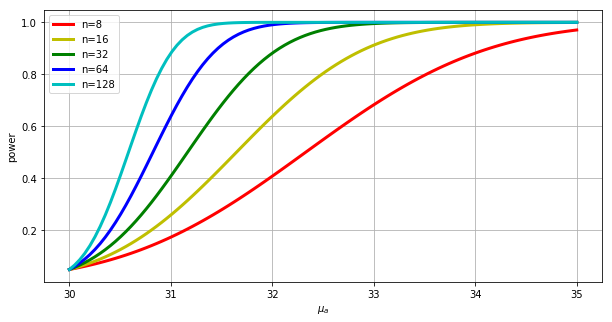

In [4]:
def power(mu_a, n):
    mu_0, alpha, sigma = 30, 0.05, 4
    z = stats.norm.ppf(1 - alpha)
    return stats.norm.sf(mu_0 + z * sigma/np.sqrt(n), loc=mu_a, scale=sigma/np.sqrt(n))

mu_a = np.linspace(30, 35, 100)

plt.figure(figsize=(10,5))
[plt.plot(mu_a, power(mu_a, n), lw=3, color=c) 
     for n,c in [(8, 'r'), (16, 'y'), (32, 'g'), (64, 'b'), (128, 'c')]
]
plt.grid()
plt.legend(['n=8', 'n=16', 'n=32', 'n=64', 'n=128'])
plt.xlabel('$\mu_a$')
plt.ylabel('power')
plt.show()

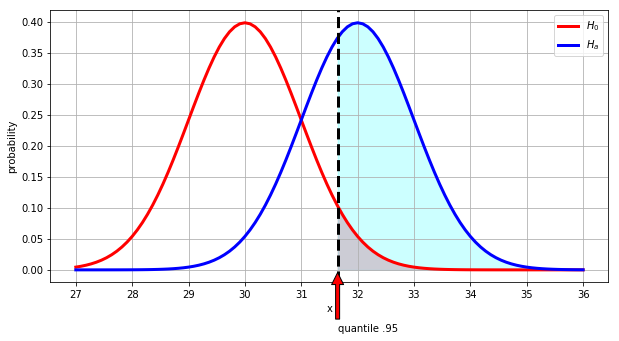

In [5]:
mu_0 = 30
mu_a = 32
sigma = 4
n = 16
alpha = 0.05

x = np.linspace(27, 36, 100)
y_0 = stats.norm.pdf(x, loc=mu_0, scale=sigma/np.sqrt(n))
y_a = stats.norm.pdf(x, loc=mu_a, scale=sigma/np.sqrt(n))
x_black = stats.norm.ppf(0.95, loc=mu_0, scale=sigma/np.sqrt(n))
x1 = np.linspace(x_black, 36, 100)

plt.figure(figsize=(10,5))
plt.plot(x, y_0, lw=3, c='r')
plt.plot(x, y_a, lw=3, c='b')
plt.legend(['$H_0$', '$H_a$'])
plt.grid()
plt.xticks(np.linspace(27, 36, 10))
plt.xlabel('x')
plt.ylabel('probability')
plt.axvline(x=x_black, c='k', linestyle='--', lw=3)
plt.annotate('quantile .95', 
            xy=(x_black, 0), 
            xytext=(x_black, -.1), 
            arrowprops = dict(facecolor='red', shrink=0.05))
plt.fill_between(x1, stats.norm.pdf(x1, loc=mu_0, scale=sigma/np.sqrt(n)), color="pink")
plt.fill_between(x1, stats.norm.pdf(x1, loc=mu_a, scale=sigma/np.sqrt(n)), color="cyan", alpha=0.2)
plt.show()

In [6]:
print(stats.norm.sf(x_black, loc=mu_a, scale=sigma/np.sqrt(n)))
print(statsmodels.stats.power.normal_power(
    effect_size=(mu_a - mu_0)/sigma, 
    nobs=16, alpha=0.05, alternative='larger')
)

0.6387600313123348
0.638760031312335


In [7]:
print('mu_0: %d, mu_a: %d' % (mu_0, mu_a))
print('sigma: ', sigma)
print('power: ', statsmodels.stats.power.ttest_power(
    effect_size=(mu_a - mu_0)/sigma, 
    nobs=16, alpha=0.05, alternative='larger'))

mu_0: 30, mu_a: 32
sigma:  4
power:  0.6040328683316007


In [8]:
print(statsmodels.stats.power.tt_solve_power(
    effect_size=(mu_a - mu_0)/sigma, 
    alpha=0.05, nobs=16, alternative='larger'))
print(statsmodels.stats.power.tt_solve_power(
    effect_size=(mu_a - mu_0)/sigma, 
    alpha=0.05, power=0.6040328, alternative='larger'))

0.6040328683316007
15.999997299353062


# Multiple tests

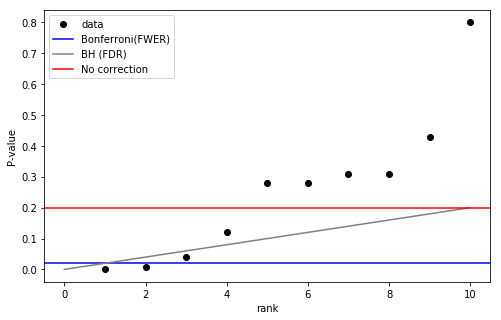

In [9]:
rank = np.array(range(10)) + 1
pValue = np.array([0.001, 0.007, 0.04, 0.12, 0.28, 0.28, 0.31, 0.31, 0.43, 0.8])
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(rank, pValue, 'o', c='k')
ax.axhline(y=0.02, c='b')
ax.plot([0, 10], [0., .2], c='gray')
ax.axhline(y=0.2, c='r')
ax.set_xlabel('rank')
ax.set_ylabel('P-value')
ax.legend(['data', 'Bonferroni(FWER)', 'BH (FDR)', 'No correction'])
plt.show()

In [10]:
n = 1000
pValues = np.zeros(n)
for i in range(n):
    x = np.random.randn(20)
    y = np.random.randn(20)
    x = sm.add_constant(x)
    est = sm.OLS(y, x).fit()
    pValues[i] = est.pvalues[1]
    
print('no correction: ', np.sum(pValues < 0.05))

no correction:  59


In [11]:
res = mt.multipletests(pValues, method='bonferroni')
print('Bonferroni correction: ', np.sum(res[1] < 0.05))

res = mt.multipletests(pValues, method='fdr_bh')
print('Benjamini/Hochberg correction: ', np.sum(res[1] < 0.05))

Bonferroni correction:  0
Benjamini/Hochberg correction:  0


In [12]:
# exemplu pentru care coeficientul w al regresiei liniare este:
# 0 pentru primele 500 de situatii construite
# 2 pentru urmatoarele
n = 1000
pValues = np.zeros(n)
for i in range(n):
    x = np.random.randn(20)
    y = np.random.randn(20) if i < n//2 else (np.random.randn(20) + 2*x)
    x = sm.add_constant(x)
    est = sm.OLS(y, x).fit()
    pValues[i] = est.pvalues[1]
    
print('no correction:', np.sum(pValues < 0.05))
res = mt.multipletests(pValues, method='bonferroni')
print('corectie FWER:' , np.sum(res[1] < 0.05))

no correction: 523
corectie FWER: 478


In [13]:
df = pd.DataFrame({
    'trueStatus': ['zero'] * 500 + ['not zero'] * 500,
    'pValue': pValues
})
pd.crosstab(df.pValue < 0.05, df.trueStatus)

trueStatus,not zero,zero
pValue,,
False,0,477
True,500,23


In [14]:
df = pd.DataFrame({
    'trueStatus': ['zero'] * 500 + ['not zero'] * 500,
    'pValueAdjusted': mt.multipletests(pValues, method='bonferroni')[1]
})
pd.crosstab(df.pValueAdjusted < 0.05, df.trueStatus)

trueStatus,not zero,zero
pValueAdjusted,,
False,22,500
True,478,0


In [15]:
df = pd.DataFrame({
    'trueStatus': ['zero'] * 500 + ['not zero'] * 500,
    'pValueAdjusted': mt.multipletests(pValues, method='fdr_bh')[1]
})
pd.crosstab(df.pValueAdjusted < 0.05, df.trueStatus)

trueStatus,not zero,zero
pValueAdjusted,,
False,0,489
True,500,11


In [16]:
adjustBonf = mt.multipletests(pValues, method='bonferroni')[1]
adjustBH = mt.multipletests(pValues, method='fdr_bh')[1]

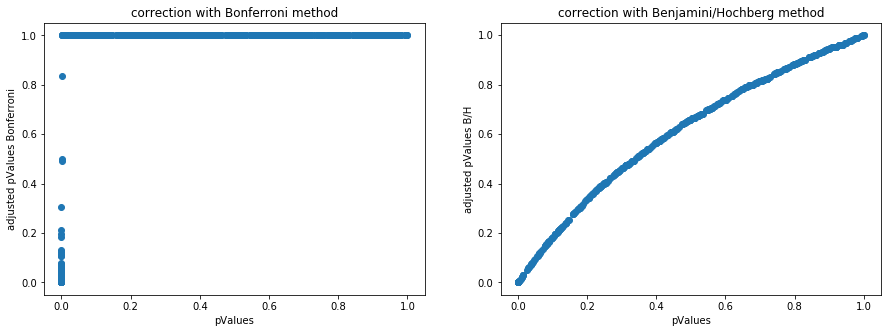

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(15, 5))
ax1.plot(pValues, adjustBonf, 'o')
ax1.set_xlabel('pValues')
ax1.set_ylabel('adjusted pValues Bonferroni')
ax1.set_title('correction with Bonferroni method')
ax2.plot(pValues, adjustBH, 'o')
ax2.set_xlabel('pValues')
ax2.set_ylabel('adjusted pValues B/H')
ax2.set_title('correction with Benjamini/Hochberg method')
plt.show()

## Bootstrap

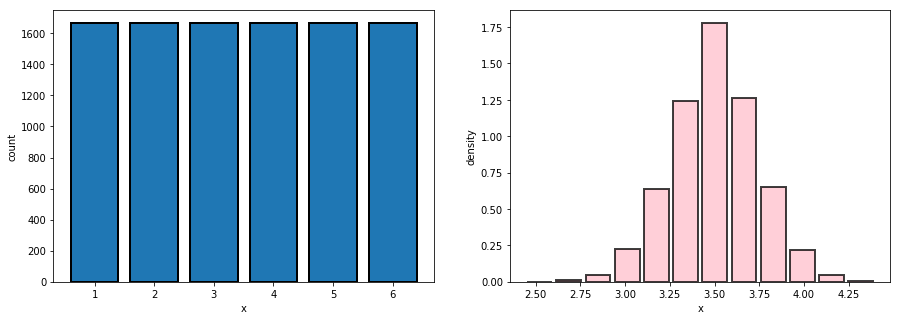

In [18]:
from functools import reduce

def roll(n):
    nosim = 10000
    x = np.random.randint(low=1, high=7, size=(nosim, n))
    return np.mean(x, axis=1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
kwargs = dict(rwidth=0.85, density=True, alpha=0.75, ec='k', linewidth=2)

ax1.bar(range(1, 7), [10000/6] * 6, linewidth=2, edgecolor='k')
ax1.set_xlabel('x')
ax1.set_ylabel('count')
ax2.hist(roll(50), bins=12, color='pink', **kwargs)
ax2.set_xlabel('x')
ax2.set_ylabel('density')
plt.show()

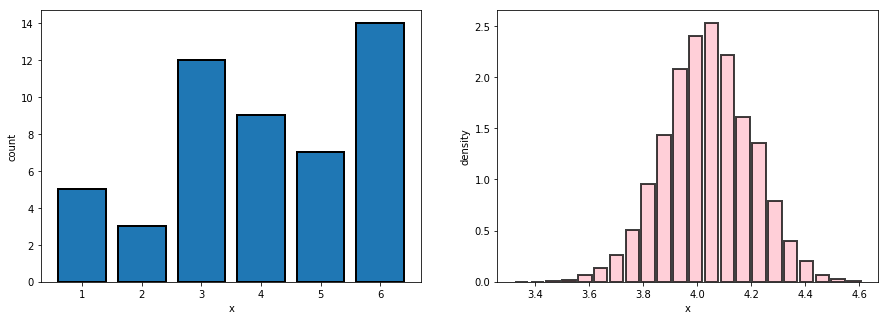

In [19]:
x = np.random.randint(low=1, high=7, size=(50))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
kwargs = dict(rwidth=0.85, density=True, alpha=0.75, ec='k', linewidth=2)

def roll(x, n):
    nosim = 10000
    x = np.random.choice(x, size=(nosim, n))
    return np.mean(x, axis=1)

l = [sum(np.array(x) == i) for i in range(1, 7)]

ax1.bar(range(1, 7), l, linewidth=2, edgecolor='k')
ax1.set_xlabel('x')
ax1.set_ylabel('count')
ax2.hist(roll(x, 100), bins=22, color='pink', **kwargs)
ax2.set_xlabel('x')
ax2.set_ylabel('density')
plt.show()

In [20]:
father_son = pd.read_csv('father_son.csv')
father_son.head()

,Unnamed: 0,fheight,sheight
0,1,65.04851,59.77827
1,2,63.25094,63.21404
2,3,64.95532,63.34242
3,4,65.75250,62.79238
4,5,61.13723,64.28113


C:\Users\Psy.Mermaid\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


deviatia standard:  0.10423799321996916
quantila 2.5%: 67.552325
quantila 97.5%: 67.94335


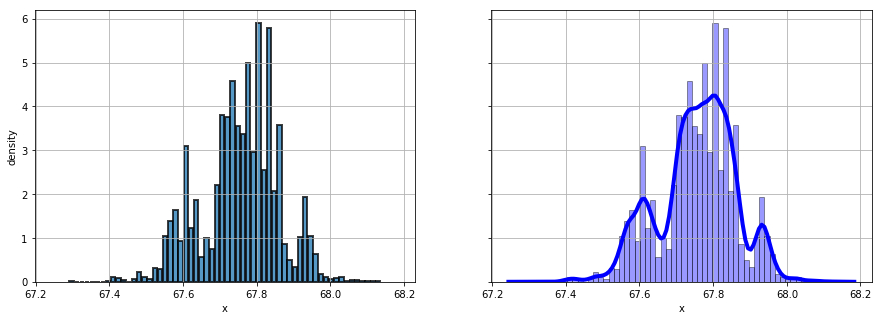

In [21]:
import seaborn

# vezi https://towardsdatascience.com/histograms-and-density-plots-in-python-f6bda88f5ac0

x = father_son.fheight.values
n, nosims = len(x), 10000
resamples = np.random.choice(x, size=(nosims, n), replace=True)
resampledMedians = np.median(resamples, axis=1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharey=True, sharex=True)
kwargs = dict(rwidth=0.85, density=True, alpha=0.75, ec='k', linewidth=2)
ax1.hist(resampledMedians, **kwargs, bins=60)
ax1.grid()
ax1.set_xlabel('x')
ax1.set_ylabel('density')
seaborn.distplot(resampledMedians, hist=True, kde=True, bins=60, ax=ax2,
    color = 'blue',  hist_kws={'edgecolor':'black'}, kde_kws={'linewidth': 4})
ax2.grid()
ax2.set_xlabel('x')

print('deviatia standard: ', np.std(resampledMedians))
print('quantila 2.5%:', np.quantile(resampledMedians, 0.025))
print('quantila 97.5%:', np.quantile(resampledMedians, 0.975))
plt.show()


In [22]:
insect_sprays = pd.read_csv('insect_sprays.csv')
insect_sprays.head()

,Unnamed: 0,count,spray
0,1,10,A
1,2,7,A
2,3,20,A
3,4,14,A
4,5,14,A


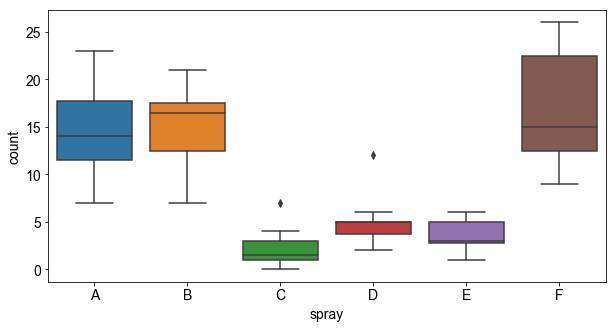

In [23]:
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
seaborn.set_style('whitegrid')
seaborn.boxplot(x='spray', y='count', data=insect_sprays, ax=ax)
plt.show()

In [24]:
def testStat(a, b, groups):
    return np.mean([y for (x, y) in zip(a, b) if x == groups[0]]) \
        - np.mean([y for (x, y) in zip(a, b) if x == groups[1]])
    
groups = ['B', 'C']
subdata = insect_sprays[insect_sprays.spray.isin(groups)]

observedStat = testStat(subdata['spray'], subdata['count'], groups)

n = subdata['spray'].values.shape[0]
nosims = 10000
permutations = np.array(list(map(
    lambda x: testStat(x, subdata['count'], groups),
    [np.random.choice(subdata['spray'].values, n) for i in range(nosims)]
)))

print(observedStat)
pValue = np.mean(permutations > observedStat)
print(pValue)

13.25
0.0


deviatia standard:  3.1536284956140355
quantila 2.5%: -6.1571428571428575
quantila 97.5%: 6.243697478991597


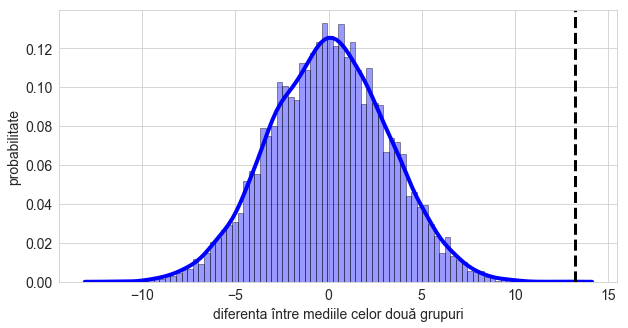

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
seaborn.distplot(permutations, hist=True, kde=True, bins=80, ax=ax,
    color = 'blue',  hist_kws={'edgecolor':'black'}, kde_kws={'linewidth': 4})
ax.grid(True)
ax.set_xlabel('diferenta între mediile celor două grupuri')
ax.set_ylabel('probabilitate')
ax.axvline(x=observedStat, lw=3, c='k', linestyle='--')

print('deviatia standard: ', np.std(permutations))
print('quantila 2.5%:', np.quantile(permutations, 0.025))
print('quantila 97.5%:', np.quantile(permutations, 0.975))
plt.show()

# Laborator

Q1. Power este o probabilitate pentru care se presupune că este adevărată:

1. ipoteza nulă $H_0$
2. ipoteza alternativă $H_a$
3. ambele

In [26]:
# R: 2.

Q2. Pe măsură ce dimensiunea sample-ului crește, restul menținîndu-se constant, ce se întâmplă cu power?

1. se mărește
2. se micșorează
3. rămâne la fel
4. nu putem preciza

In [27]:
# R: 1.
# cand sample size creste, power creste mai rapid (mai multe date colectate, mai probabil de detectat acea diferenta)

Q3. Ce se întâmplă cu power pe măsură ce $\mu_a$ se îndepărtează față de $\mu_0$ ?

In [28]:
# R: creste ( e mult mai probabil sa detectam o diferenta cand acea diferenta e foarte mare)

Q4. În contextul calculului power, ce este 'effect size'?

In [29]:
# R: effect_size = (µa − µ0) / σ 

# diferenta de medii in unitati de deviatie standard
# power creste cand 
    # µa se departeaza de µ0
    # σ (deviata standard) scade

Q5. Presupunem că în cazul unei testări A/B, o schemă de publicitate a determinat o medie de 10 achiziții pe zi pentru un sample de 100 de zile, în timp ce pentru cealaltă a determinat o medie de 11 achiziții pe zi, pentru același interval de 100 de zile. Presupunem o deviație standard de 4 achiziții pe zi pentru ambele distribuții. 

Media de 10 achiziții/zi este $\mu_0$ asociată ipotezei nule, iar pentru ipoteza alternativă $\mu_a = 11$. Care ar fi power pentru un test Z one-sided cu confidența de 95% ($\alpha=5\%$), în care presupunem că media achizițiilor a crescut la ipoteza alternativă?

In [78]:
m_0 = 10
m_a = 11
sigma = 4

power = statsmodels.stats.power.ttest_power(effect_size=(m_a - m_0)/sigma, nobs=100, alpha= 0.05, alternative='larger', df=500)
power2 = statsmodels.stats.power.normal_power(effect_size=(m_a - m_0)/sigma, nobs=100, alpha= 0.05, alternative='larger')

print('m_0:', m_0)
print('m_a:', m_a)
print('sigma:', sigma)
print('power:', power)
print('power2', power2)

m_0: 10
m_a: 11
sigma: 4
power: 0.8028268776130947
power2 0.8037649400154937


Q5. Se dorește crearea unui studiu pentru detectarea valorii medii pe 4 ani a pierderii de volum a creierului, pierdere medie de 0.01 $mm^3$. Presupunem că deviația standard pe media acestor 4 ani este de 0.04 $mm^3$. Care este numărul de voluntari pe care trebuie să se facă studiul pentru un test 5% vs. ipoteza nulă că nu se pierde deloc volum, pentru a atinge power de 80% ?

In [37]:
m_0 = 0.0
m_a = 0.01
sigma = 0.04
alpha = 0.05
power = 0.8

n = statsmodels.stats.power.tt_solve_power(effect_size=(m_a - m_0)/sigma, alpha= alpha, power=power, alternative='larger')
print('sample size:', n)

sample size: 100.2876635477728


In [38]:
def power(n):
    m_0 = 0.0
    m_a = 0.01
    sigma = 0.04
    alpha = 0.05

    return statsmodels.stats.power.normal_power(effect_size=(m_a - m_0)/sigma, nobs=n, alpha=alpha, alternative='larger')

In [39]:
def find_n():
    power_val = 0.8
    
    for n in range(1, 100):
        if round(power(n), 2) == power_val:
            return n        
    return 0

In [40]:
n = find_n()
print('sample size:', n)

sample size: 98


Q6. Un studiu a observat asocierea mai multor factor nutriționali cu cancerul mamar (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4166692/). Au fost calculate următoarele p-values:

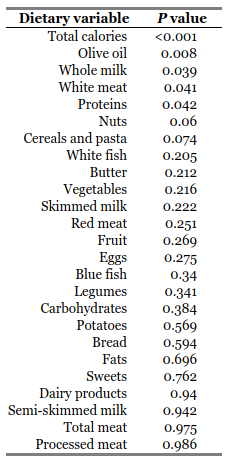

Considerăm un test cu 95% confidență.

a) Fără corecție, care factori sunt relevanți statistic ?

b) Aplicați corecția Bonferroni pe aceste p-values. Care din factori este statistic semnificativ?

c) Aplicați corecția Benjamini/Hochberg. Care factori sunt relevanți statistic în acest caz?

Reprezentați grafic p-values cu corecția Bonferroni vs. p-values fără corecție, respectiv p-values cu corecția Benjamini/Hochberg vs. p-values fără corecție. Puneți pe ambele grafice și pragul de 0.05 ca să vedem ce rejectăm și ce nu.

In [41]:
# a) factori relevanti statistic:  p-value < 0.05

In [55]:
pValues = np.array([0.008, 0.039, 0.041, 0.042, 0.06, 0.074, 0.205,
                    0.212, 0.216, 0.222, 0.275, 0.34, 0.341, 0.384, 0.569,
                    0.594, 0.969, 0.762, 0.94, 0.942, 0.975, 0.986])

print('No correction: ', np.sum(pValues < 0.05))

No correction:  4


In [56]:
# b) 
# FWER => probabilitatea de a face cel putin o eroare de tip I < alpha
# m = teste
# alpha_fwer = alpha / m
# factori relevanti: p-values < alpha_fwer

adjustBonf = mt.multipletests(pValues, method='bonferroni')
print('Bonferroni correction: ', np.sum(adjustBonf[1] < 0.05))

Bonferroni correction:  0


In [57]:
# c)
# factori relevanti: p_values < 0.05

adjustBH = mt.multipletests(pValues, method='fdr_bh')
print('Benjamini/Hochberg correction: ', np.sum(adjustBH[1] < 0.05))

Benjamini/Hochberg correction:  0


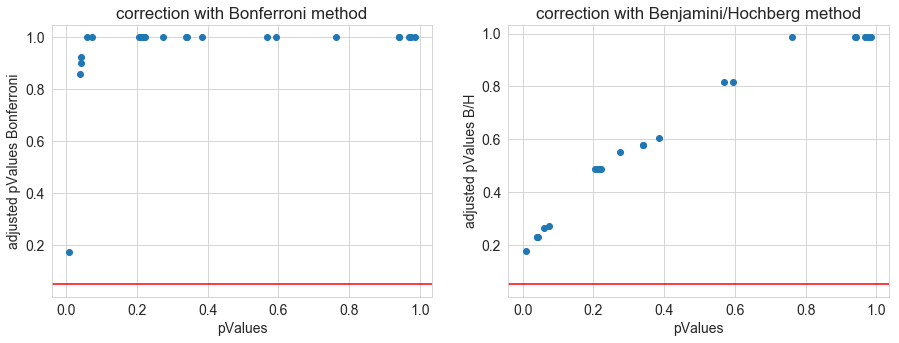

In [58]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(15, 5))

ax1.set_title('correction with Bonferroni method')
ax1.set_xlabel('pValues')
ax1.set_ylabel('adjusted pValues Bonferroni')
ax1.plot(pValues, adjustBonf[1], 'o')
ax1.axhline(0.05, c='r')

ax2.set_title('correction with Benjamini/Hochberg method')
ax2.set_xlabel('pValues')
ax2.set_ylabel('adjusted pValues B/H')
ax2.plot(pValues, adjustBH[1], 'o')
ax2.axhline(0.05, c='r')

plt.show()

Q7. Ce folosește procedura bootstrap pentru a estima distribuția sampled a unei statistici ?

In [48]:
# distributia definita de date
# in practica: 
    # simulari (se calculeaza o statistica pentru fiecare dataset simulat)
    # extrageri cu inlocuire din datele sample-ului pe care il avem       

Q8. Ce fac testele de resampling? Care este ipoteza nulă și care este ipoteza alternativă? Care este p-value?

In [49]:
# calculeaza procentajul unei simulari pentru care statistica sample-lui simulat a fost mai extrema
# (catre ipoteza alternativa), fata de cea observata
# ipoteza nula: distributiile observatiilor din fiecare grup sunt identice
# ipoteza alternativa: distributiile observatiilor sunt diferite
# p-value: valoarea pentru fiecare variabila independenta testeaza ipoteza nula

Q9. Realizați două grupuri de numere eșantionate din două distribuții, de medii 10 și respectiv 15, și dispersie 2. Etichetați fiecare sample cu numele grupului, A sau B. Grupurile au dimensiunile 40 și respectiv 50.

Ridicați whiskers plots pentru ambele grupuri.

a) Realizați testul de permutare pentru a arăta dacă numerele sunt sau nu extrase din aceeași distribuție. Stabiliți care este ipoteza nulă și care este ipoteza alternativă. Afișați distribuția mediei resample-urilor. Ce p-value obțineți pentru statistica de tip medie? Care este rezultatul testului ipotezei?

b) Creșteți dispersia grupurilor de la 2 la 10 și reluați experimentul. Ce constatați?

In [ ]:
# a)
# ipoteza nula: distributiile observatiilor din fiecare grup sunt identice
# ipoteza alternativa:  distributiile observatiilor sunt diferite

In [80]:
mu_a = 10
sigma_a = np.sqrt(2)
size_a = 40

mu_b = 15
sigma_b = np.sqrt(2)
size_b = 50

a = np.random.normal(mu_a, sigma_a, size_a)
b = np.random.normal(mu_b, sigma_b, size_b)

In [81]:
data_a = {'Value': a, 'Label': 'A'}
data_b = {'Value': b, 'Label': 'B'}
df_a = pd.DataFrame(data=data_a)
df_b = pd.DataFrame(data=data_b)
df = df_a.append(df_b)

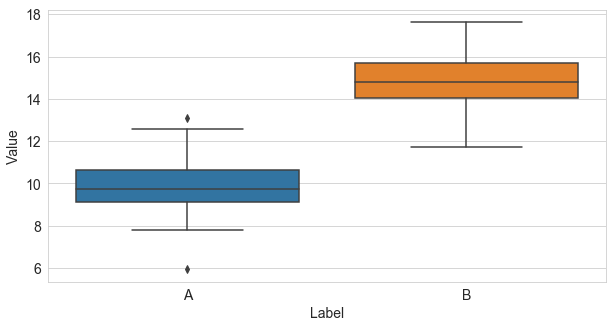

In [82]:
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
seaborn.set_style('whitegrid')
seaborn.boxplot(x='Label', y='Value', data=df, ax=ax)
plt.show()

In [70]:
def testStat(a, b, groups):
    return np.mean([y for (x, y) in zip(a, b) if x == groups[0]]) \
        - np.mean([y for (x, y) in zip(a, b) if x == groups[1]])

groups = ['B', 'A']
observedStat = testStat(df['Label'], df['Value'], groups)

n = df['Label'].values.shape[0]
nosims = 10000
permutations = np.array(list(map(
    lambda x: testStat(x, df['Value'], groups),
    [np.random.choice(df['Label'].values, n) for i in range(nosims)]
)))

print(observedStat)
pValue = np.mean(permutations > observedStat)
print(pValue)

4.632392627326329
0.0


deviatia standard:  0.6522714432225517
quantila 2.5%: -1.2776753878149456
quantila 97.5%: 1.2798696050094103


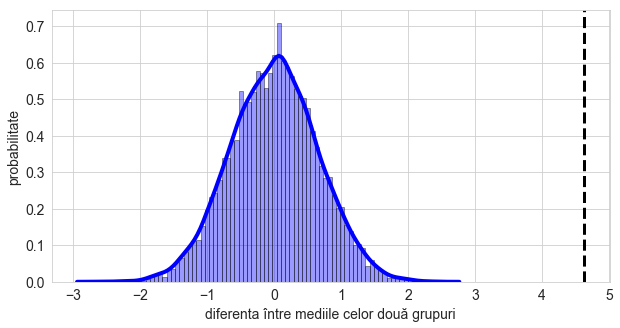

In [71]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
seaborn.distplot(permutations, hist=True, kde=True, bins=80, ax=ax,
    color = 'blue',  hist_kws={'edgecolor':'black'}, kde_kws={'linewidth': 4})
ax.grid(True)
ax.set_xlabel('diferenta între mediile celor două grupuri')
ax.set_ylabel('probabilitate')
ax.axvline(x=observedStat, lw=3, c='k', linestyle='--')

print('deviatia standard: ', np.std(permutations))
print('quantila 2.5%:', np.quantile(permutations, 0.025))
print('quantila 97.5%:', np.quantile(permutations, 0.975))
plt.show()